In [55]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import RFECV

In [61]:
# Import sample data
# Import

data_for_model = pd.read_pickle(r"C:\Users\agran\OneDrive\Desktop\abc_classification_modelling.p")
print(data_for_model)

     customer_id  signup_flag  distance_from_store gender  credit_score  \
0             74            1                 3.38      F          0.59   
1            524            1                 4.76      F          0.52   
2            607            1                 4.45      F          0.49   
3            343            0                 0.91      M          0.54   
4            322            1                 3.02      F          0.63   
..           ...          ...                  ...    ...           ...   
855          372            1                 4.38      F          0.50   
856          104            1                 2.36      F          0.63   
857          393            1                 1.87      M          0.59   
858          373            0                 0.21      M          0.47   
859          712            0                 0.07      M          0.70   

     total_sales  total_items  transaction_count  product_area_count  \
0        1586.89          1

In [63]:
# Drop unecessary columns
data_for_model.drop("customer_id", axis =1, inplace = True)

In [65]:
data_for_model

,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,1,3.38,F,0.59,1586.89,195,26,5,61.034231
1,1,4.76,F,0.52,2397.26,258,27,5,88.787407
2,1,4.45,F,0.49,1279.91,183,22,5,58.177727
3,0,0.91,M,0.54,967.14,102,17,5,56.890588
4,1,3.02,F,0.63,1566.35,182,30,5,52.211667
...,...,...,...,...,...,...,...,...,...
855,1,4.38,F,0.50,1381.28,103,12,5,115.106667
856,1,2.36,F,0.63,1464.62,127,22,5,66.573636
857,1,1.87,M,0.59,2213.97,191,38,5,58.262368
858,0,0.21,M,0.47,1446.00,133,22,5,65.727273


In [67]:
# Shuffle data
data_for_model = shuffle(data_for_model, random_state = 42)


In [69]:
# Class Balance
data_for_model["signup_flag"].value_counts(normalize  = True)

signup_flag
0    0.689535
1    0.310465
Name: proportion, dtype: float64

In [71]:
# Deal with Missing Values
data_for_model.isna().sum()


signup_flag             0
distance_from_store     5
gender                  5
credit_score            8
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [73]:
data_for_model.dropna(how = "any", inplace = True)

In [75]:
# Deal with outliers
outlier_investigation = data_for_model.describe()
outlier_columns = ["distance_from_store", "total_sales", "total_items"]

In [77]:
# Boxplot approach
for column in outlier_columns:
    lower_quartile = data_for_model[column].quantile(0.25)
    upper_quartile = data_for_model[column]. quantile(0.75)
    iqr = upper_quartile - lower_quartile
    iqr_extended = iqr*2
    min_border = lower_quartile - iqr_extended
    max_border = upper_quartile + iqr_extended
    
    outliers = data_for_model[(data_for_model[column]<min_border) | (data_for_model[column] > max_border)].index
    print(f'{len(outliers)} outliers detected in column {column}')
    
    data_for_model.drop(outliers, inplace = True)

8 outliers detected in column distance_from_store
54 outliers detected in column total_sales
3 outliers detected in column total_items


In [79]:
# Split Input Variables & Output Variables
X = data_for_model.drop(["signup_flag"], axis = 1)
y = data_for_model["signup_flag"]

In [81]:
X.columns

Index(['distance_from_store', 'gender', 'credit_score', 'total_sales',
       'total_items', 'transaction_count', 'product_area_count',
       'average_basket_value'],
      dtype='object')

In [83]:
# Split out traing and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify= y)

In [85]:
# Deal with Categorical Variables

categorical_vars = ["gender"]
one_hot_encoder = OneHotEncoder(sparse_output = False, drop = "first")

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop = True), X_train_encoded.reset_index(drop = True)], axis = 1)
X_train.drop(categorical_vars, axis  = 1, inplace = True)

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop= True), X_test_encoded.reset_index(drop = True)], axis = 1)
X_test.drop(categorical_vars, axis = 1, inplace = True)

In [87]:
# Feature scaling

scale_norm = MinMaxScaler()
X_train = pd.DataFrame(scale_norm.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scale_norm.transform(X_test), columns = X_test.columns)

In [89]:
# Feature selection

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state = 42)
feature_selector = RFECV(clf)

fit = feature_selector.fit(X_train, y_train)

optimal_feature_count = feature_selector.n_features_
print(f"Optimal number of features: {optimal_feature_count}")

X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]


Optimal number of features: 6


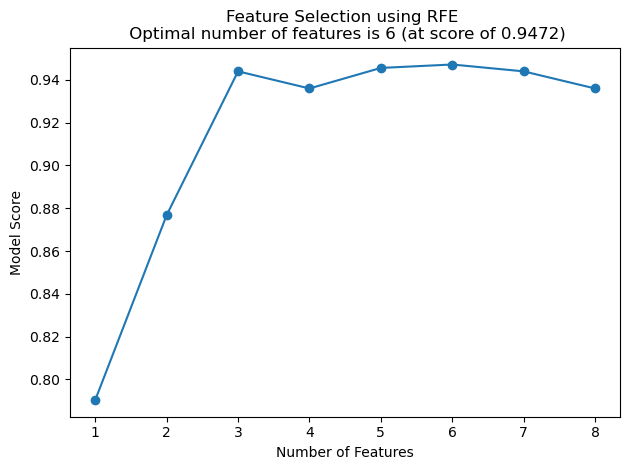

In [99]:
plt.plot(range(1, len(fit.cv_results_["mean_test_score"]) + 1), fit.cv_results_["mean_test_score"], marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.cv_results_['mean_test_score']), 4)})")
plt.tight_layout()
plt.show()

In [101]:
# Model Training
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)


KNeighborsClassifier()

In [103]:
# Model Assessment

y_pred_class = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

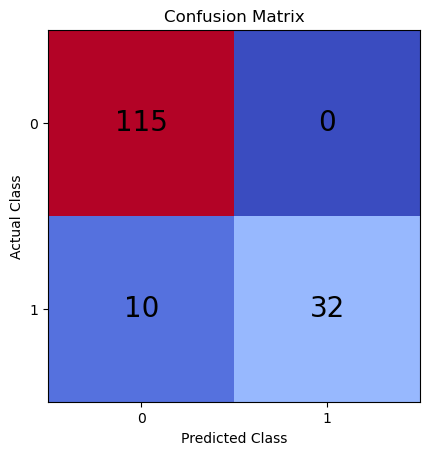

In [107]:
# Confusion Matrix

conf_matrix = confusion_matrix(y_test, y_pred_class)
plt.matshow(conf_matrix, cmap = "coolwarm")
plt.gca().xaxis.tick_bottom()
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
for (i,j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j, i, corr_value, ha = "center", va = "center", fontsize = 20)
plt.show()

In [109]:
# Accuracy (the number of correct classification out of all attempted classification)
accuracy_score(y_test, y_pred_class)

0.9363057324840764

In [111]:
# Precision (of all observations that were predicted as positive, how many were actually positive)
precision_score(y_test, y_pred_class)


1.0

In [113]:
# Recall (of all positive observations, how many did we predict as positive)
recall_score(y_test, y_pred_class)

0.7619047619047619

In [115]:
# F1- score (the harmonic mean of precision and recall)
f1_score(y_test, y_pred_class)

0.8648648648648648

In [117]:
# Find the optimal of k

k_list = list(range(2,25))
accuracy_scores = []

for k in k_list:
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = f1_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
max_accuracy = max(accuracy_scores)
max_accuracy_idx = accuracy_scores.index(max_accuracy)
optimal_k_value = k_list[max_accuracy_idx]

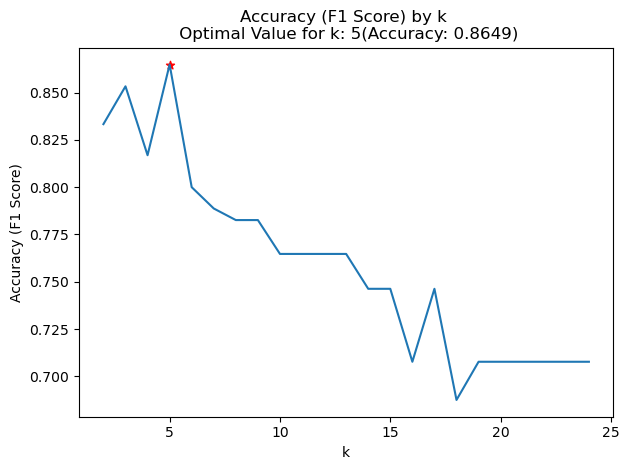

In [119]:
# Plot of max depths

plt.plot(k_list, accuracy_scores)
plt.scatter(optimal_k_value, max_accuracy, marker = "*", color = "red")
plt.title(f"Accuracy (F1 Score) by k \n Optimal Value for k: {optimal_k_value}(Accuracy: {round(max_accuracy,4)})")
plt.xlabel("k")
plt.ylabel("Accuracy (F1 Score)")
plt.tight_layout()
plt.show()